# Semi Direct Effects: Having a Closer Look on Profiles Again

## Libs

In [1]:
%matplotlib inline

import os, sys
import pylab as plt
import numpy as np
import numpy

import seaborn as sns
sns.set_context('talk')

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%H')

import xarray as xr
xr.set_options(keep_attrs=True)

import nawdex_analysis.io.tools


/pf/b/b380352/.conda/python37/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Data Input

**Data Description**

The data aggregates have been collected and resampled in [06-Semi-Direct-Effects_Save_Domave_Aggregates.ipynb](06-Semi-Direct-Effects_Save_Domave_Aggregates.ipynb)

In [2]:
fdir = '%s/icon-lem/aggregates' % (os.environ['LOCAL_DATA_PATH'],  )
fname = '%s/domain_average_resampled5min.nc' % fdir
dset = xr.open_dataset( fname ).isel( time = slice(1, 288))
    

## Data Preparation 

### Precip

In [3]:
vname = 'rain_gsp_rate'
P = dset[vname]

In [4]:
dt = 5* 60
dset['rain_accum'] = ( P * dt).cumsum('time')
dset['rain_accum'].attrs = dict( long_name = 'accumulated rain', units = 'kg m-2')
diff = dset.sel( mode = 'absorbing') - dset.sel(mode = 'scattering')

### Evaporation 

In [6]:
L   = 2.5e6  # enthalpy of evaporation

E = - dset['lhfl_s'] / L
dset['evaporation_rate'] = E
dset['eva_accum'] = ( E * dt).cumsum('time')

diff = dset.sel( mode = 'absorbing') - dset.sel(mode = 'scattering')

## Plotting 

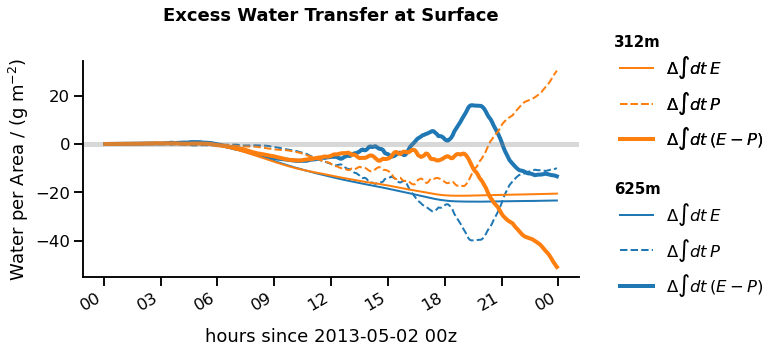

In [7]:
Qv = 1e3 * diff['prw']
LWP = 1e3 * diff['clwvi']
IWP = 1e3 * diff['clivi']

Q_tot = 0
for vname in ['clwvi', 'clivi', 'tqg', 'tqh', 'tqr']:
    Q_tot += 1e3 * diff[vname]

P = 1e3 * diff['rain_accum']
E = 1e3 * diff['eva_accum']


fig, axs = plt.subplots(  figsize = (12, 5) )
plt.subplots_adjust(right = 0.7, top = 0.8, bottom = 0.2)

cols = ['C0', 'C1']
doms = ['DOM01', 'DOM02']
dlab = ['312m', '625m']
qlab = [#'$\Delta Q_v$', 
        '$\Delta \int dt \, E$', 
        '$\Delta \int dt \, P$', 
        '$\Delta \int dt \, (E - P)$', ]
for i, dom in enumerate( doms ):
#    Qv.sel( dom = dom).plot( ax = axs, lw = 3, 
#                             label = '%s' % qlab[0],
#                             c = cols[i])
#    
#    ((Qv + Q_tot )).sel( dom = dom).plot( ax = axs, lw = 1, 
#                             label = '%s' % qlab[0],
#                             c = cols[i])
    
    
    E.sel(dom = dom).plot( ax = axs, lw = 2, ls = '-',                              
                           label = '%s' % qlab[0],
                           c = cols[i])

    P.sel(dom = dom).plot( ax = axs, lw = 2, ls = '--',                              
                           label = '%s' % qlab[1],
                           c = cols[i])

    (E - P).sel(dom = dom).plot( ax = axs, ls = '-', lw = 4, 
                                 label = '%s' % qlab[2],
                                 c = cols[i])

    # plt.legend(loc = 'upper left', ncol = 2, bbox_to_anchor = (0.05,1.1), title = dlab[i])


sns.despine()
plt.title('Excess Water Transfer at Surface', fontweight = 'bold', pad = 40)
plt.ylabel('Water per Area / (g m${}^{-2}$)')
plt.axhline(0, color = 'gray', lw = 5, alpha = 0.3)
#plt.ylim(-39, 39)

lines, labels = axs.get_legend_handles_labels()
legend1 = plt.legend(lines[:3], labels[:3], loc = 'upper right', bbox_to_anchor = (1.4, 0.42), 
                     frameon = False, )
legend2 = plt.legend(lines[3:], labels[3:], loc = 'upper right', bbox_to_anchor = (1.4, 1.1),
                     frameon = False, )

i = 0
ypos = [0.84, 0.43]
for legend_title in dlab:
    plt.figtext(0.74, ypos[i], legend_title, fontsize = 'small', fontweight = 'bold')
    i += 1
axs.add_artist(legend1)
axs.add_artist(legend2)

plt.gca().xaxis.set_major_formatter(myFmt)
plt.xlabel('hours since 2013-05-02 00z', labelpad = 15 )

plt.savefig( '../pics/excess_water_at_surface.png', dpi = 300. )